In [1]:
import pygame, sys
import math
import random as rn
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline
plt.rcParams.update({'figure.figsize': [8,5]})

sys.path.append('procedural_tracks/')
from procedural_tracks.main import *

np.set_printoptions(precision=3, suppress=True)

pygame 2.1.0 (SDL 2.0.16, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# helper functions

def get_track_points_from_random_track(seed=8, sample=20):
    rn.seed(seed)  
    points = random_points()
    hull = ConvexHull(points)
    track_points_coarse = shape_track(get_track_points(hull, points))
    corner_points = get_corners_with_kerb(track_points_coarse)
    track_points = smooth_track(track_points_coarse)[::sample]
    return track_points

def racing_line_length(points): 
    x,y = zip(*points)
    num_points = len(points)
    length = np.sum([np.sqrt((x[i] - x[i+1])**2 + (y[i] - y[i+1])**2) 
                     for i in range(num_points-1)])
    return length

# this is slightly incorrect, the new point can be (max_offset, max_offset) away
# use a 2d gaussian instead?
def get_new_point(old_point, baseline, spread, max_offset_from_baseline):
    old_x, old_y = old_point
    baseline_x, baseline_y = baseline
    while True:
        potential_x = old_x + (np.random.random()-0.5) * spread
        if abs(potential_x - baseline_x) < max_offset_from_baseline:
            new_x = potential_x
            break
    while True:
        potential_y = old_y + (np.random.random()-0.5) * spread
        if abs(potential_y - baseline_y) < max_offset_from_baseline:
            new_y = potential_y
            break
    return new_x, new_y

In [11]:
# cost functions

def racing_line_length_full(points_except_last, params={}): 
    points = copy.deepcopy(points_except_last)
    points += [points[0]]
    x,y = zip(*points)
    num_points = len(points)
    length = np.sum([np.sqrt((x[i] - x[i+1])**2 + (y[i] - y[i+1])**2) 
                     for i in range(num_points-1)])
    return length

def _angle_between(vector1, vector2):
    vector1_unit = vector1 / np.linalg.norm(vector1)
    vector2_unit = vector2 / np.linalg.norm(vector2)
    angle = np.arccos(np.clip(np.dot(vector1_unit, vector2_unit), -1.0, 1.0))
    sign = np.sign(np.cross(vector1_unit, vector2_unit))
    return angle * sign
    
def sum_of_angles(points_except_last, params={}):
    num_points = len(points_except_last)
    points = copy.deepcopy(points_except_last)
    points += [points[0]]
    
    vectors = [(points[i+1][0] - points[i][0], points[i+1][1] - points[i][1]) for i in range(num_points)]
    vectors += [vectors[0]]
    angles = [abs_angle_between(vectors[i], vectors[i+1]) for i in range(len(vectors)-1)]
    return np.std(angles), angles
    
def _length_and_angles(points_except_last):
#     length = racing_line_length_full(points_except_last)
#     angles = sum_of_angles(points_except_last)
    points = copy.deepcopy(points_except_last)
    points += [points[0]]
    x,y = zip(*points)
    num_points = len(points)
    vectors = [(x[i+1] - x[i], y[i+1] - y[i]) for i in range(num_points-1)]
    vectors += [vectors[0]]
    
    length = np.sum([np.sqrt(vectors[i][0]**2 + vectors[i][1]**2) for i in range(len(vectors)-1)])
    angles = np.std([_angle_between(vectors[i], vectors[i+1]) for i in range(len(vectors)-1)])
    
    return (length, angles)

def length_and_angles(points_except_last, params={'reg_param': 0.0, 'init_cost': (1.0, 1.0)}):
    reg_param = params['reg_param']
    init_cost = params['init_cost']
    
    length, angles = _length_and_angles(points_except_last)
    length_init, angles_init = init_cost
    length_normalized = length / length_init
    angles_normalized = angles / angles_init
    
    cost = length_normalized + reg_param * angles_normalized
    return cost

In [14]:
# checking how the cross product can help differentiate between, say, +90 and -90

x1 = [1,0]
y1 = [-1,-1] / np.sqrt(2)
print(np.cross(x1, y1), np.arccos(np.dot(x1, y1)))
x2 = [1,0]
y2 = [-1,-1] / np.sqrt(2)
print(np.cross(x2, y2), np.arccos(np.dot(x2, y2)))
print(_angle_between(x1, y1))
print(_angle_between(x2, y2))

0.7071067811865475 2.356194490192345
-0.7071067811865475 2.356194490192345
2.356194490192345
-2.356194490192345


In [16]:
# optimization functions

def opt_random_perturbation(track_midpoints, compute_cost=racing_line_length_full,
                            spread=10, iterations=100, track_width=0.65,
                            debug=False, debug_iter=1000):
    
    best_racing_line = []
    best_racing_line_cost = np.inf
    num_track_points = np.array(track_midpoints).shape[0]
    max_offset_from_baseline = track_width/2
    racing_line = [0] * (num_track_points)
    
    for iteration in range(iterations):
        for i in range(num_track_points):
            new_x, new_y = get_new_point(track_midpoints[i], track_midpoints[i], 
                                         spread, max_offset_from_baseline)
            racing_line[i] = (new_x, new_y)
        cost = compute_cost(racing_line)
        if cost < best_racing_line_cost:
            best_racing_line = copy.deepcopy(racing_line)
            best_racing_line_cost = cost
        if debug:
            if iteration % debug_iter == 0:
                print(f'Best hiterto: {best_racing_line_cost:.3f}')
    return best_racing_line, best_racing_line_cost

def opt_iterative_improvement(track_midpoints, compute_cost=racing_line_length_full,
                              cost_func_params={},
                              spread=10, iterations=100, track_width=0.65,
                              debug=False, debug_iter=1000):
    
    num_track_points = np.array(track_midpoints).shape[0]
    racing_line_old = copy.deepcopy(track_midpoints)
    racing_line_new = copy.deepcopy(racing_line_old)
    max_offset_from_baseline = track_width/2
    init_cost = compute_cost(racing_line_old)
    print(f'Started with: {init_cost}')
    min_cost_so_far = init_cost
    
    for iteration in range(iterations):
        min_cost_iter = min_cost_so_far
        point = (-1, (0,0))
        for i in range(num_track_points):     # can randomly sample points here
            new_x, new_y = get_new_point(racing_line_old[i], track_midpoints[i], 
                                         spread, max_offset_from_baseline)
            racing_line_new[i] = (new_x, new_y)
            cost = compute_cost(racing_line_new, cost_func_params)
            if cost < min_cost_iter:
                point = (i, (new_x, new_y))
                min_cost_iter = cost
            racing_line_new[i] = racing_line_old[i]
        if min_cost_iter < min_cost_so_far:
            racing_line_new[point[0]] = point[1]
            min_cost_so_far = min_cost_iter
        if debug:
            if iteration % debug_iter == 0:
                print(f'Smallest hiterto: {min_cost_so_far:.3f}')
                #print(np.array(racing_line_new))
        racing_line_old = copy.deepcopy(racing_line_new)
    
    print(f'\nEnded with: {compute_cost(racing_line_new)}\n')
    return racing_line_new

In [17]:
# visualization functions

def draw_track_and_racing_line(track_points, racing_line, track_width, 
                               compute_cost=racing_line_length_full,
                               xlims=None, ylims=None, smooth=False, smooth_points=1000):
    track_points_x, track_points_y = zip(*track_points)
    plt.scatter(track_points_x, track_points_y, s=1000*track_width, color='black', facecolor='None')
    if xlims != None:
        plt.xlim((-2, 6))
    if ylims != None:
        plt.ylim((-2, 6))
#     print(compute_cost(racing_line))
    racing_line = copy.deepcopy(racing_line)
    racing_line += [racing_line[0]]
    x, y = zip(*racing_line)
    plt.plot(x, y, 'or')
    if smooth:
        tck, u = interpolate.splprep([x, y], s=0, per=True)
        xi, yi = interpolate.splev(np.linspace(0, 1, smooth_points), tck)
        plt.plot(xi, yi, '-b')
    else:
        plt.plot(x, y, '-b')
    #print(f'Length of racing line: {racing_line_length(racing_line):.3f}')
    
def draw_complete_track(track_seed=8, racing_line=None):
    pygame.init()
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    background_color = GRASS_GREEN
    screen.fill(background_color)
    
    rn.seed(track_seed)  # 8 is a nice simple track
    points = random_points()
    hull = ConvexHull(points)
    track_points = shape_track(get_track_points(hull, points))
    corner_points = get_corners_with_kerb(track_points)
    f_points = smooth_track(track_points)
    # get complete corners from keypoints
    corners = get_full_corners(f_points, corner_points)
    # draw the actual track (road, kerbs, starting grid)
    draw_track(screen, GREY, f_points, corners)
    # draw racing line
    draw_lines_from_points(screen, BLUE, racing_line)
    # draw checkpoints
    checkpoints = get_checkpoints(f_points)

    pygame.display.set_caption(TITLE)
    while True: # main loop
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()
                sys.exit()
        pygame.display.update()

### Loading and checking a sample track

In [6]:
rn.seed(8)  # 8 is a nice simple track
points = random_points()
hull = ConvexHull(points)
track_points = shape_track(get_track_points(hull, points))
corner_points = get_corners_with_kerb(track_points)
f_points = smooth_track(track_points)
# get complete corners from keypoints
corners = get_full_corners(f_points, corner_points)

In [7]:
len(f_points)

1000

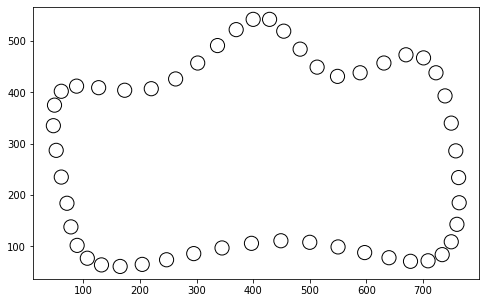

In [8]:
track_midpoints = np.array(f_points)
track_midpoints_x, track_midpoints_y = zip(*track_midpoints)
plt.scatter(track_midpoints_x[::20], track_midpoints_y[::20], s=200, color='black', facecolor='None')

## Sanity checks on smaller tracks

In [17]:
track_points = [[0,0], [4,0], [4,4], [0,4]]
track_width = 2

16.0 0.0
(16.0, 0.0)


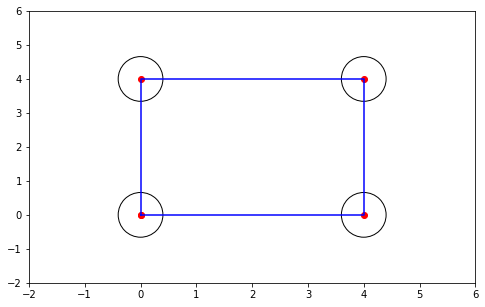

In [18]:
draw_track_and_racing_line(track_points, track_points, track_width, xlims=(-2,6), ylims=(-2,6))
length_init, angles_init = _length_and_angles(track_points)
print(length_init, angles_init)
print(_length_and_angles(track_points))    # stddev of all 90-degree angles is zero.

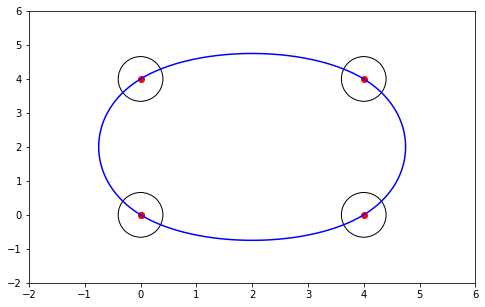

In [11]:
draw_track_and_racing_line(track_points, track_points, track_width, xlims=(-2,6), ylims=(-2,6), smooth=True)

(14.022269531217113, 0.03712369780786822)


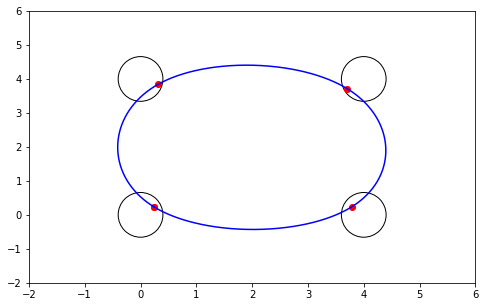

In [19]:
# Compute shortest racing line using the random-perturbation algorithm

shortest_racing_line, _ = opt_random_perturbation(track_points, spread=0.8, iterations=100000)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6), smooth=True)
print(_length_and_angles(shortest_racing_line))

Started with: 16.0

Ended with: 13.454968315538542



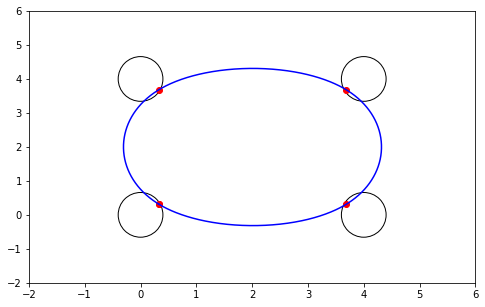

In [16]:
# Compute shortest racing line using the iterative-improvement algorithm

shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=racing_line_length_full,
                                                 spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6), smooth=True)

Started with: 16.0

Ended with: 13.468211083972049

13.468211083972049


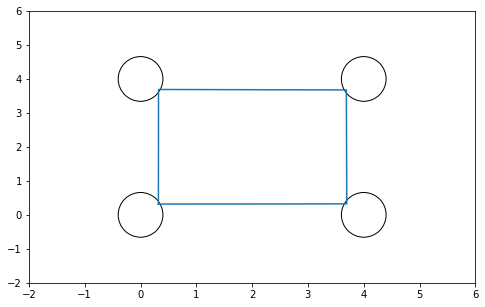

In [80]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.5, 'init_cost': init_cost},
                                                 spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6))

(16.0, 0.0)
Started with: 16.0

Ended with: 12.489145752073737

(12.489145752073737, 0.31735716777335665)


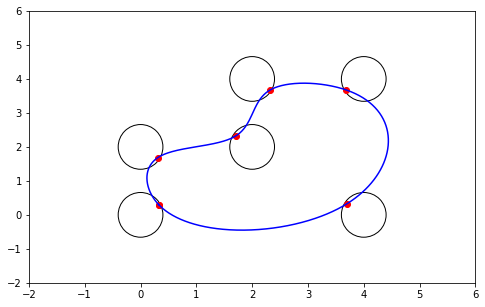

In [20]:
# new track
track_points = [[0,0], [4,0], [4,4], [2,4], [2,2], [0,2]]

print(_length_and_angles(track_points))

shortest_racing_line = opt_iterative_improvement(track_points, spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2, xlims=(-2,6), ylims=(-2,6), smooth=True)
print(_length_and_angles(shortest_racing_line))

Started with: 16.0

Ended with: 12.436464574973094



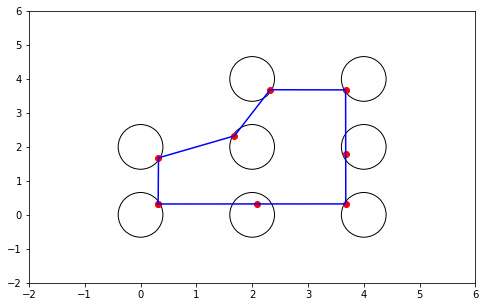

In [22]:
# new track
track_points = [[0,0], [2,0], [4,0], [4,2], [4,4], [2,4], [2,2], [0,2]]

shortest_racing_line = opt_iterative_improvement(track_points, spread=0.8, iterations=5000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6))

In [ ]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.0, 'init_cost': init_cost},
                                                 spread=0.8, iterations=1000,
                                                 debug=False, debug_iter=1)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width, xlims=(-2,6), ylims=(-2,6))

Seems to be working well enough. Back to the larger track(s).

In [7]:
rn.seed(8)  # 8 is a nice simple track
points = random_points()
hull = ConvexHull(points)
track_points_coarse = shape_track(get_track_points(hull, points))
corner_points = get_corners_with_kerb(track_points_coarse)
track_points = smooth_track(track_points_coarse)[::20]

2124.290518902025


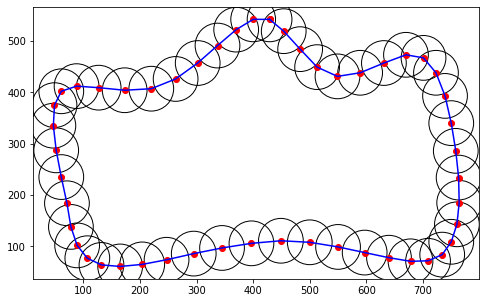

In [8]:
draw_track_and_racing_line(track_points, track_points, track_width=2)#, xlims=(-2,6), ylims=(-2,6))
print(length_and_angles(track_points))

Started with: 2124.290518902025

Ended with: 1780.0701917445356



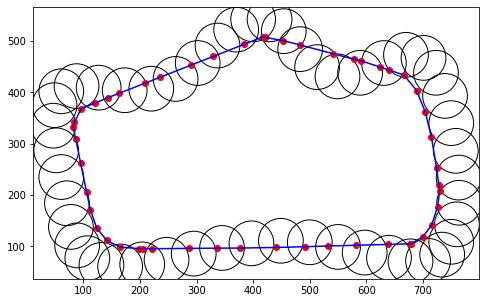

In [10]:
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=racing_line_length_full,
                                                 spread=70, iterations=1000,
                                                 debug=False, debug_iter=10, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, 
                           compute_cost=racing_line_length_full,
                           track_width=2)#, xlims=(-2,6), ylims=(-2,6))

Ooh la la

In [11]:
# will open a new window, closing which throws the following (harmless) exception
draw_complete_track(racing_line=shortest_racing_line)

SystemExit: 

/Users/anaik/venvs/dev/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


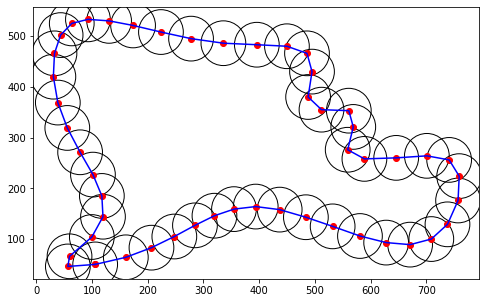

In [12]:
# new track

track_points = get_track_points_from_random_track(seed=123, sample=20)
draw_track_and_racing_line(track_points, track_points, track_width=2)

Started with: 2263.023804183427

Ended with: 1812.57659676271



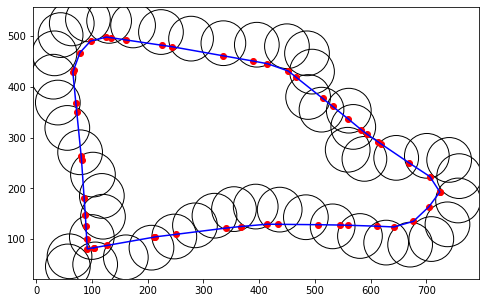

In [13]:
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=racing_line_length_full,
                                                 spread=70, iterations=1000,
                                                 debug=False, debug_iter=10, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, 
                           compute_cost=racing_line_length_full, track_width=2)

(2008.7614738659981, 0.46453024004407584)


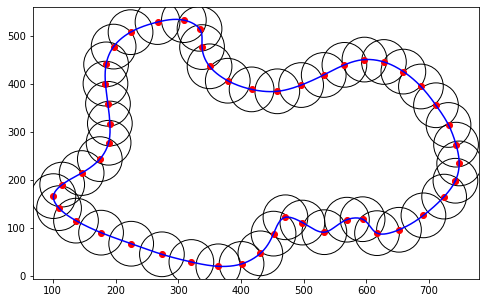

In [18]:
# new track

track_points = get_track_points_from_random_track(seed=95521, sample=20)
draw_track_and_racing_line(track_points, track_points, track_width=2, smooth=True, smooth_points=1000)
print(_length_and_angles(track_points))

Started with: 2008.7614738659981

Ended with: 1568.8123968515847

(1568.8123968515847, 0.25214091427821195)


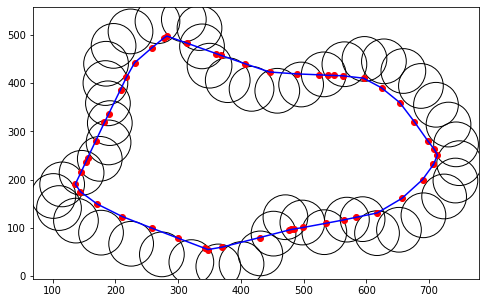

In [19]:
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=racing_line_length_full,
                                                 spread=70, iterations=1000,
                                                 debug=False, debug_iter=10, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, 
                           compute_cost=racing_line_length_full, track_width=2)
print(_length_and_angles(shortest_racing_line))

(1577.8686382233298, 0.2951767382908652)


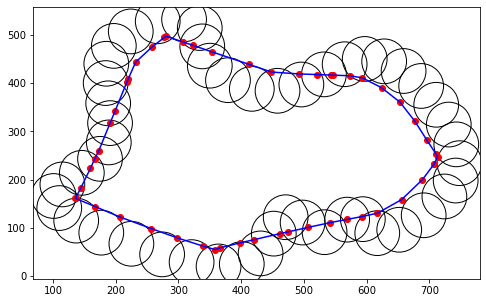

In [26]:
draw_track_and_racing_line(track_points, shortest_racing_line, 
                           compute_cost=racing_line_length_full, track_width=2, smooth=False, smooth_points=2000)
print(_length_and_angles(shortest_racing_line))

### In quest for a more realistic cost function

Started with: 2008.7614738659981
Smallest hiterto: 1.946
Smallest hiterto: 1.573
Smallest hiterto: 1.530
Smallest hiterto: 1.513
Smallest hiterto: 1.499
Smallest hiterto: 1.489
Smallest hiterto: 1.487
Smallest hiterto: 1.482
Smallest hiterto: 1.478
Smallest hiterto: 1.476
Smallest hiterto: 1.476
Smallest hiterto: 1.474
Smallest hiterto: 1.470
Smallest hiterto: 1.468
Smallest hiterto: 1.468
Smallest hiterto: 1.468
Smallest hiterto: 1.466
Smallest hiterto: 1.464
Smallest hiterto: 1.462
Smallest hiterto: 1.461

Ended with: 1932.3123588180938

(1932.3123588180938, 0.23146527497362773)


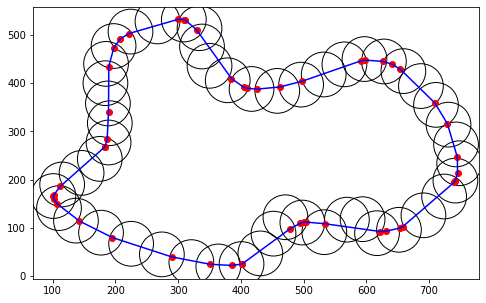

In [20]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 1, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.500
Smallest hiterto: 1.271
Smallest hiterto: 1.224
Smallest hiterto: 1.211
Smallest hiterto: 1.201
Smallest hiterto: 1.195
Smallest hiterto: 1.188
Smallest hiterto: 1.179
Smallest hiterto: 1.178
Smallest hiterto: 1.175
Smallest hiterto: 1.173
Smallest hiterto: 1.172
Smallest hiterto: 1.171
Smallest hiterto: 1.171
Smallest hiterto: 1.170
Smallest hiterto: 1.170
Smallest hiterto: 1.170
Smallest hiterto: 1.169
Smallest hiterto: 1.168
Smallest hiterto: 1.167

Ended with: 1890.0436225290784

(1890.0436225290784, 0.20993616250541222)


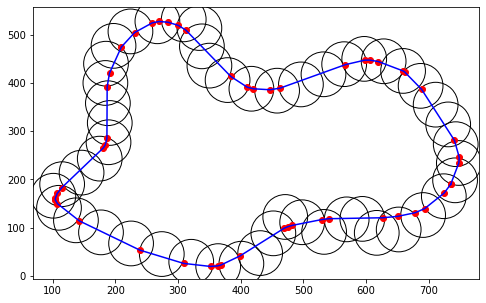

In [21]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.5, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.087
Smallest hiterto: 1.009
Smallest hiterto: 0.996
Smallest hiterto: 0.983
Smallest hiterto: 0.976
Smallest hiterto: 0.967
Smallest hiterto: 0.963
Smallest hiterto: 0.961
Smallest hiterto: 0.959
Smallest hiterto: 0.958
Smallest hiterto: 0.958
Smallest hiterto: 0.957
Smallest hiterto: 0.957
Smallest hiterto: 0.957
Smallest hiterto: 0.956
Smallest hiterto: 0.955
Smallest hiterto: 0.955
Smallest hiterto: 0.955
Smallest hiterto: 0.954
Smallest hiterto: 0.954

Ended with: 1815.57896930199

(1815.57896930199, 0.2292022389184361)


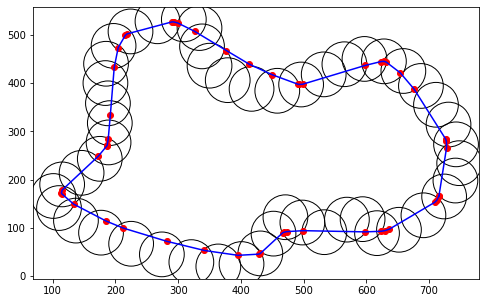

In [22]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.1, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.023
Smallest hiterto: 0.957
Smallest hiterto: 0.923
Smallest hiterto: 0.907
Smallest hiterto: 0.901
Smallest hiterto: 0.895
Smallest hiterto: 0.890
Smallest hiterto: 0.886
Smallest hiterto: 0.883
Smallest hiterto: 0.877
Smallest hiterto: 0.875
Smallest hiterto: 0.874
Smallest hiterto: 0.874
Smallest hiterto: 0.873
Smallest hiterto: 0.873
Smallest hiterto: 0.872
Smallest hiterto: 0.870
Smallest hiterto: 0.865
Smallest hiterto: 0.861
Smallest hiterto: 0.855

Ended with: 1689.0205829639276

(1689.0205829639276, 0.20915996926787772)


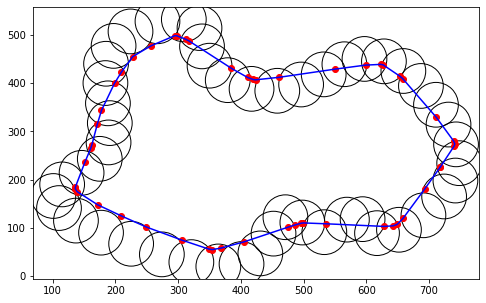

In [23]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.03, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.003
Smallest hiterto: 0.914
Smallest hiterto: 0.883
Smallest hiterto: 0.859
Smallest hiterto: 0.848
Smallest hiterto: 0.838
Smallest hiterto: 0.829
Smallest hiterto: 0.823
Smallest hiterto: 0.817
Smallest hiterto: 0.814
Smallest hiterto: 0.812
Smallest hiterto: 0.807
Smallest hiterto: 0.805
Smallest hiterto: 0.800
Smallest hiterto: 0.799
Smallest hiterto: 0.798
Smallest hiterto: 0.798
Smallest hiterto: 0.798
Smallest hiterto: 0.796
Smallest hiterto: 0.792

Ended with: 1581.9304948812212

(1581.9304948812212, 0.19263225305717765)


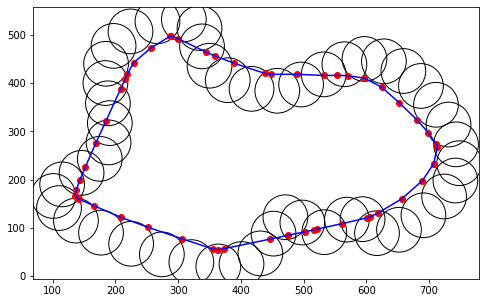

In [24]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.01, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.013
Smallest hiterto: 0.947
Smallest hiterto: 0.903
Smallest hiterto: 0.875
Smallest hiterto: 0.858
Smallest hiterto: 0.851
Smallest hiterto: 0.847
Smallest hiterto: 0.843
Smallest hiterto: 0.842
Smallest hiterto: 0.840
Smallest hiterto: 0.839
Smallest hiterto: 0.839
Smallest hiterto: 0.839
Smallest hiterto: 0.836
Smallest hiterto: 0.836
Smallest hiterto: 0.835
Smallest hiterto: 0.835
Smallest hiterto: 0.835
Smallest hiterto: 0.834
Smallest hiterto: 0.834

Ended with: 1658.7582124717687

(1658.7582124717687, 0.1903974181236872)


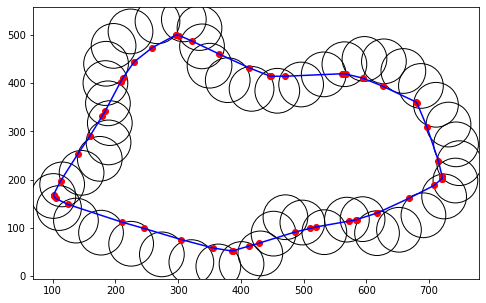

In [25]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.02, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 1.014
Smallest hiterto: 0.921
Smallest hiterto: 0.887
Smallest hiterto: 0.867
Smallest hiterto: 0.858
Smallest hiterto: 0.852
Smallest hiterto: 0.839
Smallest hiterto: 0.835
Smallest hiterto: 0.834
Smallest hiterto: 0.832
Smallest hiterto: 0.832
Smallest hiterto: 0.831
Smallest hiterto: 0.830
Smallest hiterto: 0.829
Smallest hiterto: 0.824
Smallest hiterto: 0.813
Smallest hiterto: 0.811
Smallest hiterto: 0.810
Smallest hiterto: 0.810
Smallest hiterto: 0.810

Ended with: 1614.5539789372197

(1614.5539789372197, 0.180942873408488)


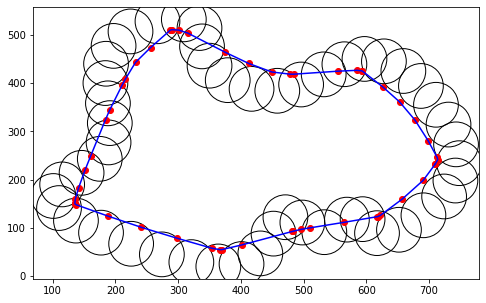

In [26]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.015, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

Started with: 2008.7614738659981
Smallest hiterto: 0.996
Smallest hiterto: 0.895
Smallest hiterto: 0.846
Smallest hiterto: 0.818
Smallest hiterto: 0.805
Smallest hiterto: 0.798
Smallest hiterto: 0.795
Smallest hiterto: 0.790
Smallest hiterto: 0.787
Smallest hiterto: 0.786
Smallest hiterto: 0.783
Smallest hiterto: 0.783
Smallest hiterto: 0.782
Smallest hiterto: 0.782
Smallest hiterto: 0.782
Smallest hiterto: 0.781
Smallest hiterto: 0.781
Smallest hiterto: 0.781
Smallest hiterto: 0.781
Smallest hiterto: 0.781

Ended with: 1567.9559559215286

(1567.9559559215286, 0.23462286355752374)


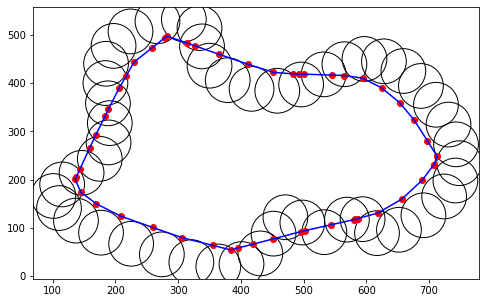

In [16]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.0, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))

In [ ]:
# Compute shortest racing line using the iterative-improvement algorithm
init_cost = _length_and_angles(track_points)
shortest_racing_line = opt_iterative_improvement(track_points, compute_cost=length_and_angles,
                                                 cost_func_params = {'reg_param': 0.01, 'init_cost': init_cost},
                                                 spread=70, iterations=1000,
                                                 debug=True, debug_iter=50, track_width=70)
draw_track_and_racing_line(track_points, shortest_racing_line, track_width=2)
print(_length_and_angles(shortest_racing_line))